# Estimating Physics Parameters

This notebook shows how the estimation phase of Spyral works. To use this notebook the ClusterPhase of Spyral *must* have been run on the data. Once clusters have been identified, the next step is to estimate the physics parameters which will be feed to the solver phase (either InterpSolverPhase or InterpLeastSqSolverPhase). For more details on the different phases, see the Spyral [documentation](https://attpc.github.io/Spyral).

## Setup
First we import  the required modules

In [1]:
from spyral.core.cluster import Cluster
from spyral.core.estimator import estimate_physics
from spyral.geometry.circle import generate_circle_points
from spyral.core.run_stacks import form_run_string
from spyral import EstimateParameters, DetectorParameters

from pathlib import Path
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

Now that we have our modules, we need to specifiy our configuration as per usual

In [2]:
# Set some parameters
workspace_path = Path("/Volumes/researchEXT/O16/no_efield/no_field_fitracks_v1.0/")

est_params = EstimateParameters(
    min_total_trajectory_points=30, smoothing_factor=100.0
)

det_params = DetectorParameters(
    magnetic_field=2.85,
    electric_field=45000.0,
    detector_length=1000.0,
    beam_region_radius=25.0,
    micromegas_time_bucket=10.0,
    window_time_bucket=560.0,
    get_frequency=6.25,
    garfield_file_path=Path("/path/to/some/garfield.txt"),
    do_garfield_correction=False,
)

cluster_path = workspace_path / "Cluster" # This may change if you add custom phases!

Open our file and make our event iterator

In [3]:
run_number = 104

cluster_file_path = cluster_path / f"{form_run_string(run_number)}.h5"
cluster_file = h5.File(cluster_file_path, "r")
cluster_group = cluster_file["cluster"]
min_event = cluster_group.attrs["min_event"]
max_event = cluster_group.attrs["max_event"]
event_iter = iter(range(min_event, max_event+1))
print(f"First event: {min_event} Last event: {max_event}")

First event: 1927598 Last event: 1992841


## Analysis

Re-running the code below this cell will walk through the events in order, so long as the cells above are not re-run.

First we select a specific event to look at

In [4]:
plt.close()
nclusters = 0
event = 1942730
# You can also hardcode an event if you want!
# event = 2
if event is None:
    try:
        event = next(event_iter)
    except StopIteration:
        raise Exception("You ran out of events in this file (wow!), open a new file to look at.")
event_name = f"event_{event}"
if event_name not in cluster_group:
    raise Exception("This was a downscale beam event and was removed from the dataset! Rerun this cell to select a new event!")
event_group = cluster_group[f"event_{event}"]
nclusters = event_group.attrs["nclusters"]
if nclusters == 0:
    raise Exception(f"There are no clusters for event {event}, run this cell again!")
cluster_iter = iter(range(0, nclusters))

print(f"Event: {event}")
print(f"N Clusters: {nclusters}")

Event: 1942730
N Clusters: 5


Now we"ll select a specific cluster to look at from that event (assuming the event has some clusters! If you got an error in the above cell, run it again!). If you run the cell below without running the cell above, you"ll walk through the set of clusters for a given event

In [5]:
cluster_index = 4
# You can also hardcode a cluster if you want!
# cluster_index = 0
if cluster_index is None:
    try:
        cluster_index = next(cluster_iter)
    except StopIteration:
        raise Exception("You ran out of clusters for this event, move to the next event (run the cell above this one)")
local_cluster = event_group[f"cluster_{cluster_index}"]
cluster = Cluster(event, local_cluster.attrs["label"], local_cluster.attrs["direction"],local_cluster["cloud"][:].copy())

print(f"Cluster index: {cluster_index}")
print(f"Cluster size: {len(cluster.data)}")

Cluster index: 4
Cluster size: 45


Let's visualize if the vertex is indeed the first point of the track

In [6]:

# result = estimate_physics(
#     cluster_index, 
#     cluster, 
#     event_group.attrs["ic_amplitude"], 
#     event_group.attrs["ic_centroid"], 
#     event_group.attrs["ic_integral"], 
#     event_group.attrs["ic_multiplicity"], 
#     event_group.attrs["orig_run"],
#     event_group.attrs["orig_event"],
#     est_params, 
#     det_params, 
# )

# fig, axs = plt.subplot_mosaic(
#     """
#     AAB
#     """,
#     per_subplot_kw={
#         "A": {
#             "projection": "3d", 
#             "box_aspect": (2,1,1),
#             "aspect": "equalxy"
#         }
#     },
#     figsize=(15.0, 5.0),
#     constrained_layout=True
# )
# axs["A"].scatter(cluster.data[:, 2], cluster.data[:, 0], cluster.data[:, 1], c="black", s=3, label="Cluster")
# # axs["A"].scatter(result[:,2], result[:,0], result[:,1], c="indianred",s=15, zorder=2, label="Initial Vertex")
# # axs["A"].scatter(result[2][2], result[2][0], result[2][1], c="cornflowerblue",s=15, zorder=2, label="Refitted Vertex")
# # axs["A"].scatter(result[0][2], result[0][0], result[0][1], c="red", s=10, label="Pointcloud", zorder=2)
# # axs["A"].scatter(result[1][:,2], result[1][:,0], result[1][:,1], c="red", s=10, label="Pointcloud", zorder=2)
# axs["A"].set_xlim3d(0., 1000.0)
# axs["A"].set_xlabel("Z(mm)")
# axs["A"].set_ylim3d(-300.0, 300.0)
# axs["A"].set_ylabel("X(mm)")
# axs["A"].set_zlim3d(-300.0, 300.0)
# axs["A"].set_zlabel("Y(mm)")
# axs["B"].scatter(cluster.data[:, 0], cluster.data[:, 1], c="black", s=3,zorder=1)
# axs["B"].plot(result[0][:,0], result[0][:,1], c="red", zorder=2, label="Before circle fit")
# axs["B"].scatter(result[2][0], result[2][1], c="red",s=10, zorder=3, label="Center before fit")
# axs["B"].plot(result[1][:,0], result[1][:,1], c="blue", zorder=2, label="Before circle fit")
# axs["B"].scatter(result[3][0], result[3][1], c="green",s=10, zorder=3, label="Center after fit")
# # axs["B"].scatter(result[1][:,0], result[1][:,1], c="blue",s=10, zorder=2, label="Refitted Arc")
# # axs["B"].scatter(result[3][0], result[3][1], c="indianred",s=15, zorder=2, label="Initial Vertex")
# # axs["B"].scatter(result[2][0], result[2][1], c="cornflowerblue",s=15, zorder=2, label="Refitted Vertex")
# # axs["B"].scatter(result[1][:,0], result[1][:,1], c="red", s=10,zorder=2)
# axs["B"].set_xlim(-300.0, 300.0)
# axs["B"].set_xlabel("X(mm)")
# axs["B"].set_ylim(-300.0, 300.0)
# axs["B"].set_ylabel("Y(mm)")
# axs["B"].grid()
# plt.suptitle(f"Run {run_number} Event {event} Cluster {cluster_index}")
# plt.legend()
# plt.show()

# display(fig)

With our cluster selected and loaded, we can now send it, along with some configuration paramters, through the estimator code and plot the results

In [7]:
result = estimate_physics(
    cluster_index, 
    cluster, 
    event_group.attrs["ic_amplitude"], 
    event_group.attrs["ic_centroid"], 
    event_group.attrs["ic_integral"], 
    event_group.attrs["ic_multiplicity"], 
    event_group.attrs["orig_run"],
    event_group.attrs["orig_event"],
    est_params, 
    det_params, 
)
if result is None:
    raise Exception("This cluster failed the estimation analysis, try a different one!")

# The plotting

rho_mm = result.brho/det_params.magnetic_field * 1000.0 * np.sin(result.polar)
length_samples = np.linspace(1.0, 50.0, 50)
dir_x_samples = length_samples * np.cos(result.azimuthal) + result.vertex_x
dir_y_samples = length_samples * np.sin(result.azimuthal) + result.vertex_y
circle_points = generate_circle_points(result.center_x, result.center_y, rho_mm)
beam_region = generate_circle_points(0., 0., det_params.beam_region_radius)
print(f"Brho(T*m): {result.brho}")
print(f"Rho(mm): {rho_mm}")
print(f"dEdx: {result.dEdx}")
print(f"Polar(deg):{result.polar * 180.0/np.pi}")
print(f"Azimuthal(deg):{result.azimuthal * 180.0/np.pi}")
print(f"Direction: {result.direction}")
print(f"Circle center x: {result.center_x} y: {result.center_y}")
print(f"Vertex z: {result.vertex_z} x: {result.vertex_x} y: {result.vertex_y} Cluster z start: {cluster.data[0, 2]}")


AttributeError: 'numpy.int64' object has no attribute 'value'

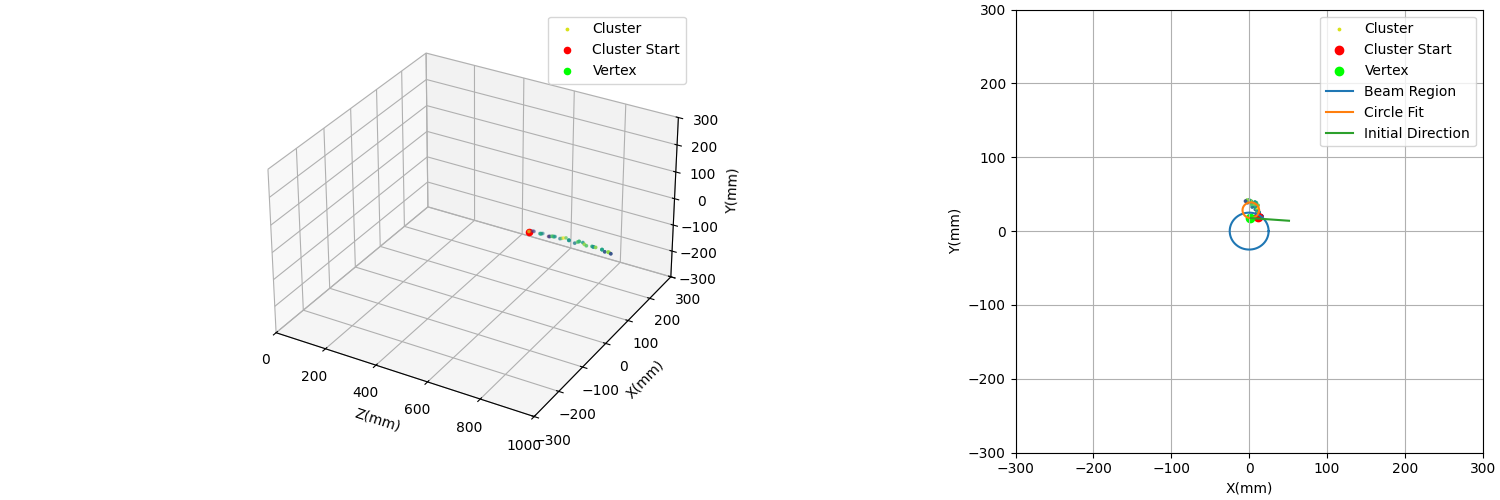

In [ ]:
fig, axs = plt.subplot_mosaic(
    """
    AAB
    """,
    per_subplot_kw={
        "A": {
            "projection": "3d", 
            "box_aspect": (2,1,1),
            "aspect": "equalxy"
        }
    },
    figsize=(15.0, 5.0),
    constrained_layout=True
)
axs["A"].scatter(cluster.data[:, 2], cluster.data[:, 0], cluster.data[:, 1], c=cluster.data[:, 3], s=3, label="Cluster")
axs["A"].scatter(cluster.data[0, 2], cluster.data[0, 0], cluster.data[0, 1], c="red", label="Cluster Start")
axs["A"].scatter([result.vertex_z], [result.vertex_x], [result.vertex_y], c="lime", label="Vertex")
axs["A"].set_xlim3d(0., 1000.0)
axs["A"].set_xlabel("Z(mm)")
axs["A"].set_ylim3d(-300.0, 300.0)
axs["A"].set_ylabel("X(mm)")
axs["A"].set_zlim3d(-300.0, 300.0)
axs["A"].set_zlabel("Y(mm)")
axs["B"].scatter(cluster.data[:, 0], cluster.data[:, 1], c=cluster.data[:, 3], s=3, label="Cluster")
axs["B"].scatter(cluster.data[0, 0], cluster.data[0, 1], c="red", label="Cluster Start")
axs["B"].scatter([result.vertex_x], [result.vertex_y], c="lime", label="Vertex")
axs["B"].plot(beam_region[:, 0], beam_region[:, 1], label="Beam Region")
axs["B"].plot(circle_points[:, 0], circle_points[:, 1], label="Circle Fit")
axs["B"].plot(dir_x_samples, dir_y_samples, label="Initial Direction")
axs["B"].set_xlim(-300.0, 300.0)
axs["B"].set_xlabel("X(mm)")
axs["B"].set_ylim(-300.0, 300.0)
axs["B"].set_ylabel("Y(mm)")
axs["B"].grid()
axs["B"].legend()
axs["A"].legend()

Now we can look at some of our results! First we'll look at the circle fit, and the estimated vertex poistion, which is how we estimate $B\rho$. We'll also draw a line corresponding to the estimated initial direction. One important part of the estimation phase is smoothing. Smoothing splines are applied to the x, y, and charge coordinates as a function of z. So your cluster might look a little different than before, but that is by design. The smoothing helps us get accurate measures for important quantities like dEdx.

In this way you can examine and tune the parameters for the estimation phase. If you want to make complete particle ID plots, it is recommended to use the particle_id.ipynb rather than these notebooks, which are more for demonstration.